In [11]:
import pandas as pd
import numpy as np
from datasets import (load_metric, Dataset, DatasetDict)
import torch
import evaluate
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorForLanguageModeling
from tqdm.auto import tqdm

torch.manual_seed(0)

In [19]:
model = 'BERT'
model_name = "google-bert/bert-base-uncased"
out_dir = f'../model/{model}'

In [3]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

train['title'] = train['title'].astype(str)
test['title'] = test['title'].astype(str)
test['label'] = test['label'].astype(str)
train['label'] = train['label'].astype(str)

In [4]:
cats = train['label'].unique()
n_labels = len(cats)
label2id = {}
id2label = {}
for i in range(len(cats)):
  label2id[cats[i]] = i
  id2label[i] = cats[i]

train = train.rename(columns={'title': 'text', 'label': 'label'})
test = test.rename(columns={'title': 'text', 'label': 'label'})
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

train['label'] = train['label'].map(label2id)
test['label'] = test['label'].map(label2id)

train_dataset = Dataset.from_dict(train)
test_dataset = Dataset.from_dict(test)
my_dataset_dict = DatasetDict({"train":train_dataset,"test":test_dataset})

In [5]:
torch.cuda.empty_cache()

In [6]:
# # Tokenize the dataset (FOR BERT)
tokenizer = AutoTokenizer.from_pretrained(model_name, id2label = id2label, label2id = label2id, max_len = 512)

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=tokenizer.model_max_length)

tokenized_datasets = my_dataset_dict.map(tokenize_function, batched=True)

small_train_dataset = tokenized_datasets["train"].shuffle(seed=0)
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=0)

Map:   0%|          | 0/1780 [00:00<?, ? examples/s]

Map:   0%|          | 0/445 [00:00<?, ? examples/s]

In [7]:
# Define the model
model = AutoModelForSequenceClassification.from_pretrained(model_name, id2label = id2label, label2id = label2id,
                                                           num_labels=n_labels, ignore_mismatched_sizes=True)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
# Define the metrics

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy_metric = evaluate.load("accuracy")
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)["accuracy"]

    if n_labels == 2:
        precision_metric = evaluate.load("precision")
        recall_metric = evaluate.load("recall")
        f1_metric = evaluate.load("f1")

        precision = precision_metric.compute(predictions=predictions, references=labels, average='macro')["precision"]
        recall = recall_metric.compute(predictions=predictions, references=labels, average='macro')["recall"]
        f1 = f1_metric.compute(predictions=predictions, references=labels, average='macro')["f1"]

        return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}
    elif n_labels > 2:
        return {"accuracy": accuracy}

In [9]:
n_epochs = 20

# training_args = TrainingArguments(output_dir=out_dir, evaluation_strategy="epoch",
#                                   save_strategy = "epoch", save_total_limit = 2,
#                                   logging_strategy = "epoch",
#                                   report_to="wandb", run_name=model,
#                                   seed = 0, num_train_epochs = n_epochs,
#                                   auto_find_batch_size = True)



training_args = TrainingArguments(output_dir=out_dir, evaluation_strategy="epoch",
                                  save_strategy = "epoch", save_total_limit = 2,
                                  logging_strategy = "epoch",
                                  seed = 0, num_train_epochs = n_epochs,
                                  auto_find_batch_size = True)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)

In [10]:
# for batch in trainer.get_train_dataloader():
#     break

# outputs = trainer.model.cpu()(**batch)

# Ensure the model is moved to the GPU
trainer.model.to('mps')

for batch in trainer.get_train_dataloader():
    # Move each tensor in the batch to the GPU
    batch = {k: v.to('mps') for k, v in batch.items()}
    break

# Compute the outputs using the model and batch on GPU
outputs = trainer.model(**batch)

device = torch.device("mps")
print(f"Device: {device}")
batch = {k: v.to(device) for k, v in batch.items()}

outputs = trainer.model.to(device)(**batch)

loss = outputs.loss
loss.backward()

trainer.create_optimizer()
trainer.optimizer.step()

Device: mps


In [12]:
# Initialize a list to store results after each epoch.
results_data = []

# Move the model to the correct device.
trainer.model.to(device)

# Iterate over epochs.
for epoch in range(n_epochs):
    # Training phase.
    trainer.model.train()
    total_train_loss = 0
    num_train_batches = 0
    train_progress_bar = tqdm(trainer.get_train_dataloader(), desc=f"Training (Epoch {epoch+1}/{n_epochs})")
    for batch in train_progress_bar:
        # Move the batch to the correct device.
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = trainer.model(**batch)
        loss = outputs.loss
        total_train_loss += loss.item()
        num_train_batches += 1
        loss.backward()
        trainer.optimizer.step()
        trainer.optimizer.zero_grad()

    avg_train_loss = total_train_loss / num_train_batches

    # Evaluation phase.
    trainer.model.eval()
    total_eval_loss = 0
    num_eval_batches = 0
    all_logits = []
    all_labels = []
    eval_progress_bar = tqdm(trainer.get_eval_dataloader(), desc=f"Evaluating (Epoch {epoch+1}/{n_epochs})")
    for batch in eval_progress_bar:
        with torch.no_grad():
            # Move the batch to the correct device.
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = trainer.model(**batch)
            logits = outputs.logits
            loss = outputs.loss
            total_eval_loss += loss.item()
            num_eval_batches += 1
            all_logits.append(logits.cpu().numpy())
            all_labels.append(batch['labels'].cpu().numpy())

    avg_eval_loss = total_eval_loss / num_eval_batches

    # Safely handle the concatenation of logits and labels.
    all_logits = np.vstack(all_logits)
    all_labels = np.concatenate(all_labels)

    # Compute metrics.
    eval_pred = (all_logits, all_labels)
    metrics = compute_metrics(eval_pred)

    # Print metrics.
    print(f"Epoch {epoch+1}/{n_epochs} - Training Loss: {avg_train_loss:.4f}, Evaluation Loss: {avg_eval_loss:.4f}, Metrics: {metrics}")

    # Store results.
    epoch_results = {
        'epoch': epoch + 1,
        'train_loss': avg_train_loss,
        'eval_loss': avg_eval_loss,
    }
    epoch_results.update(metrics)
    results_data.append(epoch_results)

# Convert the results list of dictionaries to a DataFrame.
results_df = pd.DataFrame(results_data)

Training (Epoch 1/20):   0%|          | 0/223 [00:00<?, ?it/s]

Evaluating (Epoch 1/20):   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 1/20 - Training Loss: 0.6591, Evaluation Loss: 0.6689, Metrics: {'accuracy': 0.6224719101123596, 'precision': 0.5270711024135681, 'recall': 0.5017877913238271, 'f1': 0.3999229435561549}


Training (Epoch 2/20):   0%|          | 0/223 [00:00<?, ?it/s]

Evaluating (Epoch 2/20):   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 2/20 - Training Loss: 0.6106, Evaluation Loss: 0.6762, Metrics: {'accuracy': 0.6337078651685393, 'precision': 0.5911943064095005, 'recall': 0.5466441218282858, 'f1': 0.5208067702105451}


Training (Epoch 3/20):   0%|          | 0/223 [00:00<?, ?it/s]

Evaluating (Epoch 3/20):   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 3/20 - Training Loss: 0.4798, Evaluation Loss: 0.7473, Metrics: {'accuracy': 0.6, 'precision': 0.5393258426966292, 'recall': 0.5268384095119114, 'f1': 0.5119652011041009}


Training (Epoch 4/20):   0%|          | 0/223 [00:00<?, ?it/s]

Evaluating (Epoch 4/20):   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 4/20 - Training Loss: 0.3496, Evaluation Loss: 1.0048, Metrics: {'accuracy': 0.6202247191011236, 'precision': 0.5582231318219983, 'recall': 0.5238982466721234, 'f1': 0.48179155900086135}


Training (Epoch 5/20):   0%|          | 0/223 [00:00<?, ?it/s]

Evaluating (Epoch 5/20):   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 5/20 - Training Loss: 0.2160, Evaluation Loss: 1.1533, Metrics: {'accuracy': 0.6202247191011236, 'precision': 0.548995983935743, 'recall': 0.5131391892474044, 'f1': 0.4491323679140938}


Training (Epoch 6/20):   0%|          | 0/223 [00:00<?, ?it/s]

Evaluating (Epoch 6/20):   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 6/20 - Training Loss: 0.1881, Evaluation Loss: 1.3462, Metrics: {'accuracy': 0.6157303370786517, 'precision': 0.5628846278421973, 'recall': 0.5418192392194029, 'f1': 0.5278324160311738}


Training (Epoch 7/20):   0%|          | 0/223 [00:00<?, ?it/s]

Evaluating (Epoch 7/20):   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 7/20 - Training Loss: 0.1509, Evaluation Loss: 1.2671, Metrics: {'accuracy': 0.5842696629213483, 'precision': 0.5381875985804416, 'recall': 0.5333756946538577, 'f1': 0.5309784930921522}


Training (Epoch 8/20):   0%|          | 0/223 [00:00<?, ?it/s]

Evaluating (Epoch 8/20):   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 8/20 - Training Loss: 0.1183, Evaluation Loss: 1.9313, Metrics: {'accuracy': 0.5617977528089888, 'precision': 0.5301116782271081, 'recall': 0.5297354930426916, 'f1': 0.5298506249695236}


Training (Epoch 9/20):   0%|          | 0/223 [00:00<?, ?it/s]

Evaluating (Epoch 9/20):   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 9/20 - Training Loss: 0.0859, Evaluation Loss: 1.4503, Metrics: {'accuracy': 0.5752808988764045, 'precision': 0.5214326439641321, 'recall': 0.5178132942747599, 'f1': 0.512222705524141}


Training (Epoch 10/20):   0%|          | 0/223 [00:00<?, ?it/s]

Evaluating (Epoch 10/20):   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 10/20 - Training Loss: 0.0993, Evaluation Loss: 1.3842, Metrics: {'accuracy': 0.5820224719101124, 'precision': 0.5542906991771852, 'recall': 0.5542906991771852, 'f1': 0.5542906991771852}


Training (Epoch 11/20):   0%|          | 0/223 [00:00<?, ?it/s]

Evaluating (Epoch 11/20):   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 11/20 - Training Loss: 0.0663, Evaluation Loss: 1.7923, Metrics: {'accuracy': 0.6022471910112359, 'precision': 0.5641316149742718, 'recall': 0.5585232412872098, 'f1': 0.5585540142917191}


Training (Epoch 12/20):   0%|          | 0/223 [00:00<?, ?it/s]

Evaluating (Epoch 12/20):   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 12/20 - Training Loss: 0.0466, Evaluation Loss: 2.3052, Metrics: {'accuracy': 0.5910112359550562, 'precision': 0.5541379310344827, 'recall': 0.5507258863567829, 'f1': 0.5508938869665513}


Training (Epoch 13/20):   0%|          | 0/223 [00:00<?, ?it/s]

Evaluating (Epoch 13/20):   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 13/20 - Training Loss: 0.0446, Evaluation Loss: 2.4835, Metrics: {'accuracy': 0.5820224719101124, 'precision': 0.5496063340410474, 'recall': 0.5483134450523414, 'f1': 0.5486520088993587}


Training (Epoch 14/20):   0%|          | 0/223 [00:00<?, ?it/s]

Evaluating (Epoch 14/20):   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 14/20 - Training Loss: 0.0484, Evaluation Loss: 2.5632, Metrics: {'accuracy': 0.5640449438202247, 'precision': 0.5340909090909091, 'recall': 0.5339249558437082, 'f1': 0.5339961998531761}


Training (Epoch 15/20):   0%|          | 0/223 [00:00<?, ?it/s]

Evaluating (Epoch 15/20):   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 15/20 - Training Loss: 0.1004, Evaluation Loss: 2.2174, Metrics: {'accuracy': 0.5775280898876405, 'precision': 0.548538961038961, 'recall': 0.5483026752250894, 'f1': 0.5484086885175109}


Training (Epoch 16/20):   0%|          | 0/223 [00:00<?, ?it/s]

Evaluating (Epoch 16/20):   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 16/20 - Training Loss: 0.0926, Evaluation Loss: 1.9289, Metrics: {'accuracy': 0.6134831460674157, 'precision': 0.5734908136482939, 'recall': 0.5639296945676991, 'f1': 0.563187691183856}


Training (Epoch 17/20):   0%|          | 0/223 [00:00<?, ?it/s]

Evaluating (Epoch 17/20):   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 17/20 - Training Loss: 0.0720, Evaluation Loss: 2.0983, Metrics: {'accuracy': 0.5842696629213483, 'precision': 0.5488135593220339, 'recall': 0.5465256537285141, 'f1': 0.5467708281720537}


Training (Epoch 18/20):   0%|          | 0/223 [00:00<?, ?it/s]

Evaluating (Epoch 18/20):   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 18/20 - Training Loss: 0.0627, Evaluation Loss: 2.2048, Metrics: {'accuracy': 0.5438202247191011, 'precision': 0.5492350655658087, 'recall': 0.5524059794080902, 'f1': 0.5388930574909779}


Training (Epoch 19/20):   0%|          | 0/223 [00:00<?, ?it/s]

Evaluating (Epoch 19/20):   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 19/20 - Training Loss: 0.0911, Evaluation Loss: 2.1730, Metrics: {'accuracy': 0.5550561797752809, 'precision': 0.5553367268613906, 'recall': 0.5590078835135484, 'f1': 0.5481538461538462}


Training (Epoch 20/20):   0%|          | 0/223 [00:00<?, ?it/s]

Evaluating (Epoch 20/20):   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 20/20 - Training Loss: 0.0681, Evaluation Loss: 2.1152, Metrics: {'accuracy': 0.6112359550561798, 'precision': 0.5703836393491566, 'recall': 0.5609356825916513, 'f1': 0.5598870347185301}


In [30]:
trainer.save_model(out_dir)

In [14]:
# Evaluate the model
results = trainer.evaluate()
trainer.save_metrics('all',results)
print(results)

  0%|          | 0/56 [00:00<?, ?it/s]

{'eval_loss': 2.1211254596710205, 'eval_accuracy': 0.6112359550561798, 'eval_precision': 0.5703836393491566, 'eval_recall': 0.5609356825916513, 'eval_f1': 0.5598870347185301, 'eval_runtime': 16.4845, 'eval_samples_per_second': 26.995, 'eval_steps_per_second': 3.397}


In [15]:
results_df

,epoch,train_loss,eval_loss,accuracy,precision,recall,f1
0,1,0.659115,0.668892,0.622472,0.527071,0.501788,0.399923
1,2,0.610603,0.676195,0.633708,0.591194,0.546644,0.520807
2,3,0.479790,0.747316,0.600000,0.539326,0.526838,0.511965
3,4,0.349578,1.004814,0.620225,0.558223,0.523898,0.481792
4,5,0.215970,1.153274,0.620225,0.548996,0.513139,0.449132
5,6,0.188139,1.346215,0.615730,0.562885,0.541819,0.527832
6,7,0.150893,1.267138,0.584270,0.538188,0.533376,0.530978
7,8,0.118340,1.931292,0.561798,0.530112,0.529735,0.529851
8,9,0.085861,1.450270,0.575281,0.521433,0.517813,0.512223
9,10,0.099300,1.384246,0.582022,0.554291,0.554291,0.554291


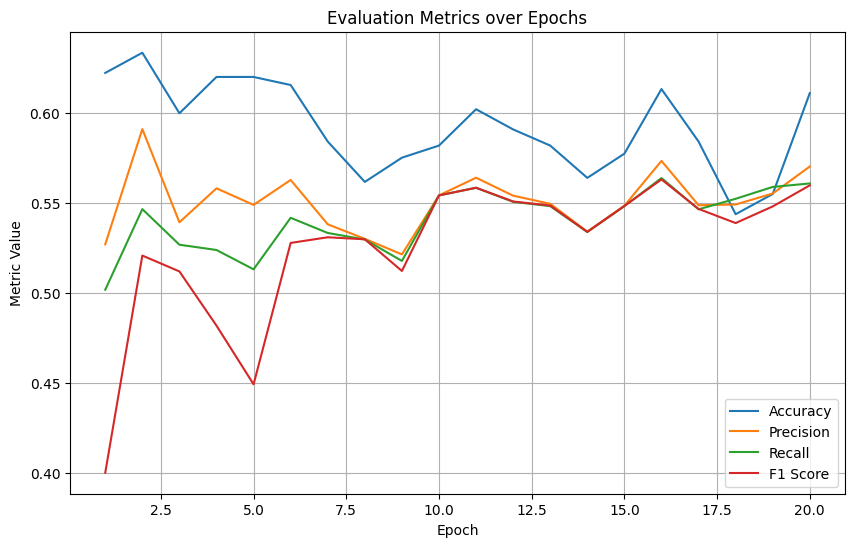

In [17]:
# Plot the results of the model evaluation
import matplotlib.pyplot as plt

# Plotting the evaluation metrics
plt.figure(figsize=(10, 6))
plt.plot(results_df['epoch'], results_df['accuracy'], label='Accuracy')
plt.plot(results_df['epoch'], results_df['precision'], label='Precision')
plt.plot(results_df['epoch'], results_df['recall'], label='Recall')
plt.plot(results_df['epoch'], results_df['f1'], label='F1 Score')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Evaluation Metrics over Epochs')
plt.legend()
plt.grid(True)
plt.show()


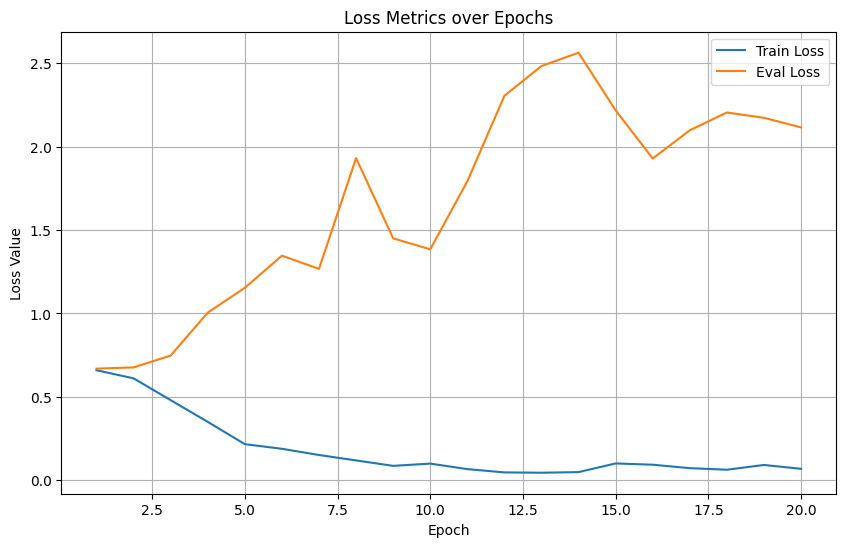

In [18]:
# Plotting the loss metrics

plt.figure(figsize=(10, 6))
plt.plot(results_df['epoch'], results_df['train_loss'], label='Train Loss')
plt.plot(results_df['epoch'], results_df['eval_loss'], label='Eval Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.title('Loss Metrics over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Upload the model to HuggingFace

In [25]:
# Upload the model to huggingface
from huggingface_hub import notebook_login
notebook_login()



In [45]:
trainer.push_to_hub("bert-contextual")

CommitInfo(commit_url='https://huggingface.co/bllin001/bert-contextual/commit/386b31c0a7c068b3f742b0ab635c57edcfb2301b', commit_message='bert-contextual', commit_description='', oid='386b31c0a7c068b3f742b0ab635c57edcfb2301b', pr_url=None, pr_revision=None, pr_num=None)

In [46]:
tokenizer.push_to_hub("bert-contextual")

README.md:   0%|          | 0.00/1.32k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/bllin001/bert-contextual/commit/7669933acdc650c85d85922e9006a12f8c768170', commit_message='Upload tokenizer', commit_description='', oid='7669933acdc650c85d85922e9006a12f8c768170', pr_url=None, pr_revision=None, pr_num=None)

In [49]:
from transformers import AutoModelForSequenceClassification

model_name = "bllin001/bert-contextual"
model = AutoModelForSequenceClassification.from_pretrained(model_name)

config.json:   0%|          | 0.00/831 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [50]:
from transformers import pipeline

classifier = pipeline("text-classification", model=model, tokenizer=model_name)

tokenizer_config.json:   0%|          | 0.00/1.30k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [51]:
title = "Pope Francis visits Venice, says his work isn't easy"
classifier(title)

[{'label': '1', 'score': 0.6637846827507019}]

In [53]:
model.config.label2id = {"not contextual": 0, "contextual": 1}
model.config.id2label = {0: "not contextual", 1: "contextual"}
model.push_to_hub("bert-contextual")

CommitInfo(commit_url='https://huggingface.co/bllin001/bert-contextual/commit/56f21b47647e02e023926b9de63ff5c2801a8874', commit_message='Upload BertForSequenceClassification', commit_description='', oid='56f21b47647e02e023926b9de63ff5c2801a8874', pr_url=None, pr_revision=None, pr_num=None)

In [54]:
classifier = pipeline("text-classification", model=model_name)
classifier(title)


config.json:   0%|          | 0.00/870 [00:00<?, ?B/s]

[{'label': 'contextual', 'score': 0.6637846827507019}]